In [43]:
#import all needed libraries and perform required configuration setup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import tldextract
import string
import spacy
from spacy.lang import punctuation
import unicodedata  # might need to pip install unicodedate2 on aws sagemaker
from contractions import contractions_dict # need to have the contractions.py file copied to your path
#from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
from collections import defaultdict
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC 
from sklearn.gaussian_process import GaussianProcessClassifier 
from sklearn.gaussian_process.kernels import RBF 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier 
from sklearn.neural_network import MLPClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
import gensim
from gensim.models import word2vec
from gensim.models.fasttext import FastText
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import STOPWORDS


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='darkgrid',palette='Dark2',rc={'figure.figsize':(9,6),'figure.dpi':90})

punctuation = string.punctuation + '”' + '“' + '–' + '““' + "’’" + '”'
stopword = stopwords.words('english')
stopwords = set(STOPWORDS)
wordnet_lemmatizer = WordNetLemmatizer()


nlp = spacy.load('en',parse=True,tag=True, entity=True)
# if you get error from the above , you will need to install the following to stage the proper file:
#python -m spacy download en_core_web_sm
#python -m spacy download en

In [46]:
%%time
df= pd.read_csv('D:/fake_news_data.csv')
df.head()

Wall time: 1min 49s


,Unnamed: 0,Unnamed: 0.1,domain,type,content,scraped_at,title,label
0,0,7766484,nytimes.com,reliable,One month after a three-judge panel of a feder...,2018-02-11 00:42:14.935145+00:00,Appeal of Challenge to ‘No Child’ Law,real
1,1,6845267,www.yahoo.com,reliable,STOCKHOLM (Reuters) - Sweden will seek assuran...,2016-11-11 14:16:53.754000+00:00,Sweden seek assurances from Trump regarding de...,real
2,2,8102733,nytimes.com,reliable,"But this week, the bus’s practices gained wide...",2018-02-11 00:45:31.225957+00:00,"At Front of Brooklyn Bus, a Clash of Religious...",real
3,3,6917956,www.yahoo.com,reliable,BEIRUT (AP) — The Latest on developments in Sy...,2016-11-08 03:28:07.118000+00:00,The Latest: Turkey: Use of Kurds against IS 'n...,real
4,4,6965379,www.sfgate.com,reliable,Hot-shooting Tennessee Tech routs Alabama A&M ...,2016-11-18 22:38:10.550000+00:00,Hot-shooting Tennessee Tech routs Alabama A&M ...,real


### Basic additional cleaning

In [47]:
# list of columns to drop from the datasets
cols_to_drop = ['Unnamed: 0', 'Unnamed: 0.1', 'type']

# drop the columns and check the memory usage
df.drop(cols_to_drop, axis=1, inplace=True)
df.head()

,domain,content,scraped_at,title,label
0,nytimes.com,One month after a three-judge panel of a feder...,2018-02-11 00:42:14.935145+00:00,Appeal of Challenge to ‘No Child’ Law,real
1,www.yahoo.com,STOCKHOLM (Reuters) - Sweden will seek assuran...,2016-11-11 14:16:53.754000+00:00,Sweden seek assurances from Trump regarding de...,real
2,nytimes.com,"But this week, the bus’s practices gained wide...",2018-02-11 00:45:31.225957+00:00,"At Front of Brooklyn Bus, a Clash of Religious...",real
3,www.yahoo.com,BEIRUT (AP) — The Latest on developments in Sy...,2016-11-08 03:28:07.118000+00:00,The Latest: Turkey: Use of Kurds against IS 'n...,real
4,www.sfgate.com,Hot-shooting Tennessee Tech routs Alabama A&M ...,2016-11-18 22:38:10.550000+00:00,Hot-shooting Tennessee Tech routs Alabama A&M ...,real


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1788000 entries, 0 to 1787999
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   domain      object
 1   content     object
 2   scraped_at  object
 3   title       object
 4   label       object
dtypes: object(5)
memory usage: 68.2+ MB


In [49]:
df['domain'] = df['domain'].astype('category')
df['scraped_at'] = pd.to_datetime(df['scraped_at'], utc=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1788000 entries, 0 to 1787999
Data columns (total 5 columns):
 #   Column      Dtype              
---  ------      -----              
 0   domain      category           
 1   content     object             
 2   scraped_at  datetime64[ns, UTC]
 3   title       object             
 4   label       object             
dtypes: category(1), datetime64[ns, UTC](1), object(3)
memory usage: 58.0+ MB


In [50]:
# checking missing values
def missing_value(df):
    """" Function to calculate the number and percent of missing values in a dataframe"""
    total = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_value = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    return missing_value

missing_value(df)

,Total,Percent
label,0,0.0
title,0,0.0
scraped_at,0,0.0
content,0,0.0
domain,0,0.0


In [51]:
# extra the day from the scraped_at column
df['day_name'] = df['scraped_at'].dt.day_name()
df.head(3)

,domain,content,scraped_at,title,label,day_name
0,nytimes.com,One month after a three-judge panel of a feder...,2018-02-11 00:42:14.935145+00:00,Appeal of Challenge to ‘No Child’ Law,real,Sunday
1,www.yahoo.com,STOCKHOLM (Reuters) - Sweden will seek assuran...,2016-11-11 14:16:53.754000+00:00,Sweden seek assurances from Trump regarding de...,real,Friday
2,nytimes.com,"But this week, the bus’s practices gained wide...",2018-02-11 00:45:31.225957+00:00,"At Front of Brooklyn Bus, a Clash of Religious...",real,Sunday


In [52]:
# get the domain name from the URL
def extract_domain(url):
    """
    Extract domain name from fld url
    """
    info = tldextract.extract(url)
    return info.domain

In [53]:
df['domain'] = df['domain'].astype(str).apply(extract_domain)
df.head(3)

,domain,content,scraped_at,title,label,day_name
0,nytimes,One month after a three-judge panel of a feder...,2018-02-11 00:42:14.935145+00:00,Appeal of Challenge to ‘No Child’ Law,real,Sunday
1,yahoo,STOCKHOLM (Reuters) - Sweden will seek assuran...,2016-11-11 14:16:53.754000+00:00,Sweden seek assurances from Trump regarding de...,real,Friday
2,nytimes,"But this week, the bus’s practices gained wide...",2018-02-11 00:45:31.225957+00:00,"At Front of Brooklyn Bus, a Clash of Religious...",real,Sunday


In [62]:
# make smaller datasets to check cleaning work
seed = 500
test_set1 = df.sample(n=1000, random_state=seed)
test_set2 = test_set1.copy()

## Text content cleaning (Ola)

In [54]:
def remove_special_characters(text): 
    """
    Removes special characters from the text document
    """
    # define the pattern to keep. You can check the regex using this url https://regexr.com/
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
    return re.sub(pat, '', text)

def remove_extra_whitespace_tabs(text): 
    """
    Removes extra whitespaces and remove_extra_whitespace_tabs
    """
    #pattern = r'^\s+$|\s+$'
    pattern = r'^\s*|\s\s*'
    return re.sub(pattern, ' ', text).strip()

def remove_digits(text): 
    """
    Remove all digits from the text document
     take string input and return a clean text without numbers.
        Use regex to discard the numbers.
    """
    result = ''.join(i for i in text if not i.isdigit()).lower()
    return ' '.join(result.split())

def remove_newlines(text): 
    """
    Remove newline characters from the text document
    """
    return text.replace('\\n', ' ').replace('\\r', ' ').replace('\n', ' ').replace('\r', ' ').replace('\\', ' ')

#normalize to the NFKD (Normalization Form Compatibility Decomposition) form
#that present in the Unicode standard to remain compatible with other encodings
def remove_accented_chars(text): 
    """
    Removes accented characters from the test
    """
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

#expands contractions found in the text
def expand_contractions(text, contraction_mapping=contractions_dict):

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# replace punctuation characters with spaces
def replace_punctuation(text):
    filters = string.punctuation + '”' + '“' + '–' 
    translate_dict = dict((c, " ") for c in filters)   
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    return text

# Remove stopwords and remove words with 2 or less characters
def stops_letters(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stopword:
            result.append(token)
            
    return " ".join(result)

#Removes any word that starts with either http or https
def remove_urls (vTEXT):
    #vTEXT = re.sub('http://\S+|https://\S+', '', vTEXT,flags=re.MULTILINE)
    vTEXT = re.sub('http[s]?://\S+', '', vTEXT,flags=re.MULTILINE)
    return(vTEXT)

#Remove words that starts with www
def remove_www (vTEXT):
    vTEXT = re.sub('www\S+', '', vTEXT,flags=re.MULTILINE)
    return(vTEXT)

In [64]:
%%time
# Apply the functions to the dataframe

# Step 1 - convert the text to lower case
test_set1['content']=test_set1['content'].apply(lambda x: x.lower())
test_set1['title']=test_set1['title'].apply(lambda x: x.lower())
test_set1['day_name']=test_set1['day_name'].apply(lambda x: x.lower())

#step 2 - Remove URLS
test_set1['content']=test_set1['content'].apply(remove_urls)
test_set1['title'] = test_set1['title'].apply(remove_urls)

#step 3 - Remove www
test_set1['content']=test_set1['content'].apply(remove_www)
test_set1['title'] = test_set1['title'].apply(remove_www)

# Step 4 - remove special charcaters
test_set1['content']=test_set1['content'].apply(remove_special_characters)
test_set1['title'] = test_set1['title'].apply(remove_special_characters)

#step 5 - Remove whitespaces and tabs
test_set1['content']=test_set1['content'].apply(remove_extra_whitespace_tabs)
test_set1['title'] = test_set1['title'].apply(remove_extra_whitespace_tabs)

#step 6 - remove newlines and tabs
test_set1['content'] = test_set1['content'].apply(remove_newlines)
test_set1['title'] = test_set1['title'].apply(remove_newlines)

# step 7 - Remove digits
test_set1['content']=test_set1['content'].apply(remove_digits)
test_set1['title'] = test_set1['title'].apply(remove_digits)

#step 8 - remove accented characters
test_set1['content']=test_set1['content'].apply(remove_accented_chars)
test_set1['title'] = test_set1['title'].apply(remove_accented_chars)

#step 9 - Expand contractions
#test_set1['content']=test_set1['content'].apply(expand_contractions)

#step 10 - Replace punctuations with spaces 
test_set1['content']= test_set1['content'].apply(replace_punctuation)
test_set1['title'] = test_set1['title'].apply(replace_punctuation)

#step 11 - Remove stopwords, tokenize and remove words with 3 letters or less
test_set1['content']= test_set1['content'].apply(stops_letters)
test_set1['title'] = test_set1['title'].apply(stops_letters)

Wall time: 3.92 s


In [68]:
test_set1.head()

,domain,content,scraped_at,title,label,day_name
680813,nutritionfacts,acrilamida patatas fritas estudios humanos sob...,2017-11-27 01:15:02.476695+00:00,nutritionfacts,real,monday
279254,nytimes,choice rely cage ching ancient chinese oracle ...,2018-02-11 00:35:42.615860+00:00,collages chance accident,real,sunday
1611176,beforeitsnews,economics politics saturday,2017-11-27 01:14:08.745400+00:00,stories contributed victoria mariatheresa valois,fake,monday
407692,nytimes,remyronald jupiter cresskill loveladies decemb...,2018-02-11 00:42:08.331112+00:00,paid notice deaths remy ronald,real,sunday
1627787,beforeitsnews,laws montana fourth edition shipping news gary...,2017-11-18 20:01:27.400599+00:00,laws montana fourth edition shipping,fake,saturday


In [69]:
test_set1.dtypes

domain                     object
content                    object
scraped_at    datetime64[ns, UTC]
title                      object
label                      object
day_name                   object
dtype: object

# Modeling! 

### Word Cloud

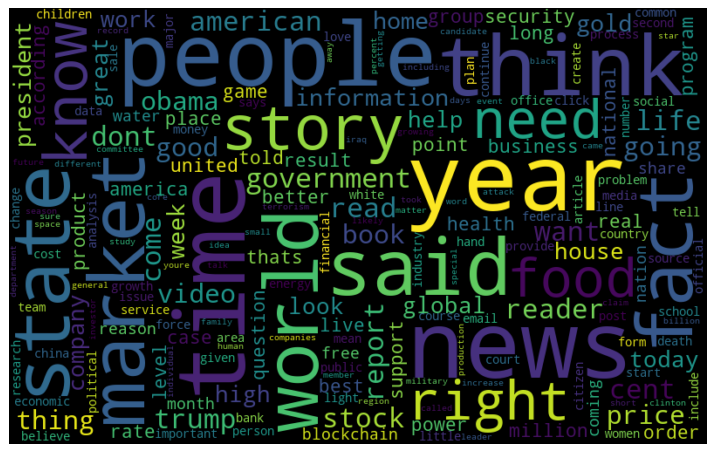

In [73]:
# Fake word cloud
fake_data = test_set1[test_set1['label'] == 'fake']
all_words = ''.join([text for text in fake_data.content])

wordcloud = WordCloud(width= 800, height= 500, max_font_size=110, collocations =
                       False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

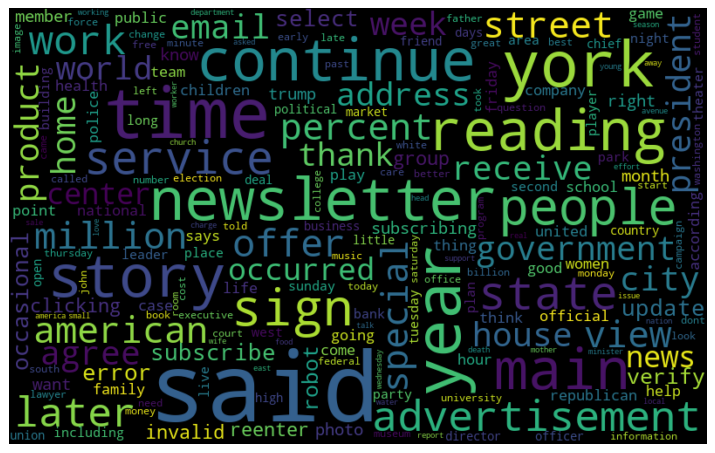

In [74]:
# Real word cloud 
real_data = test_set1[test_set1['label'] == 'real']
all_words = ''.join([text for text in real_data.content])

wordcloud = WordCloud(width= 800, height= 500, max_font_size=110, collocations =
                       False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Split data and set up confusion matrix creation

Text(0.5, 0, 'Predicted label')

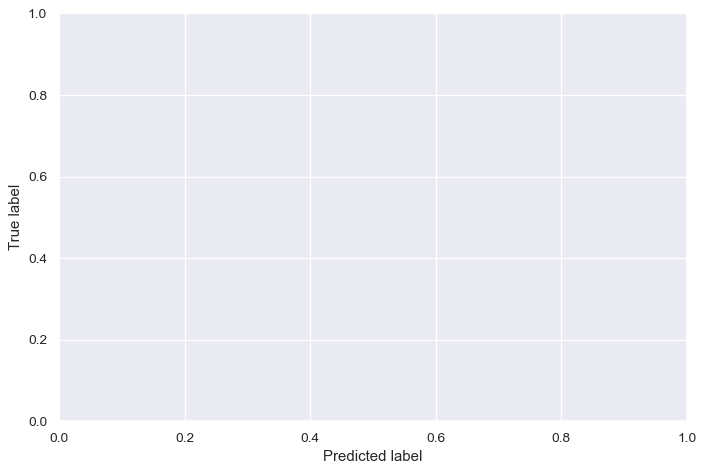

In [93]:
from sklearn import metrics
import itertools 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

<AxesSubplot:title={'center':'Distribution of real/fake articles'}>

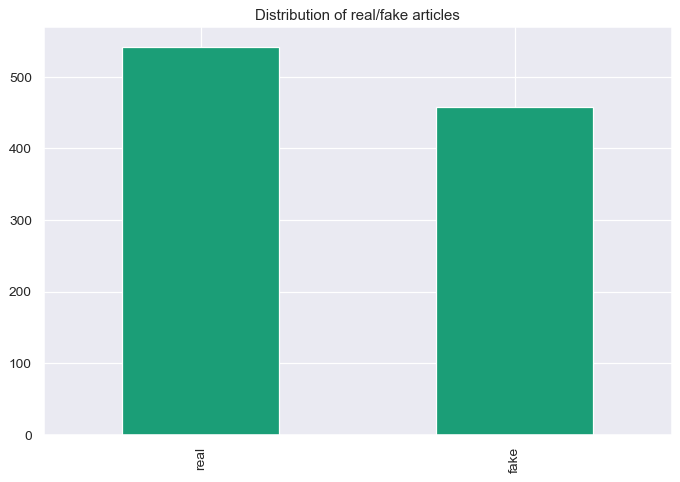

In [124]:
# check distributions of sample (real/fake)
test_set1['label'].value_counts(ascending=False).plot.bar(title= 
            'Distribution of real/fake articles')

<AxesSubplot:title={'center':'Distribution of article domains'}>

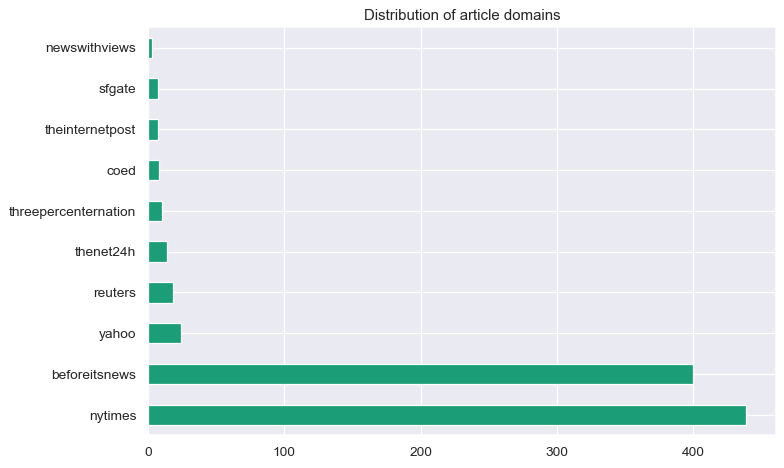

In [126]:
# check distributions of sample (real/fake)
test_set1['domain'].value_counts(ascending=False).head(10).plot.barh(title= 
            'Distribution of article domains')

<AxesSubplot:title={'center':'Distribution of article day of the week'}>

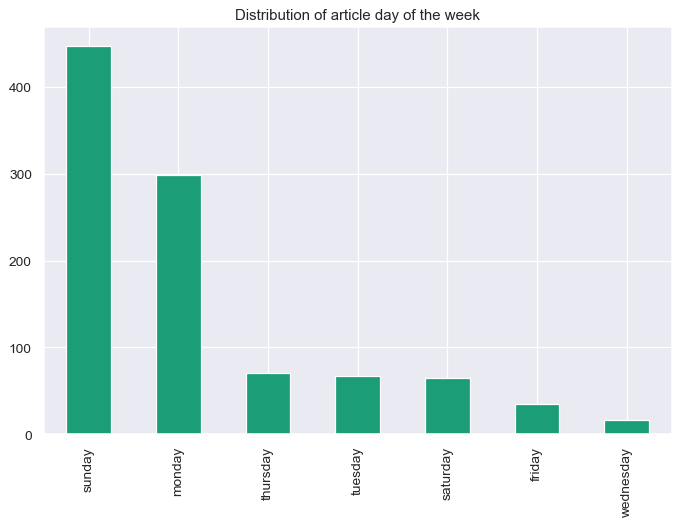

In [127]:
# check distributions of sample (real/fake)
test_set1['day_name'].value_counts(ascending=False).plot.bar(title= 
            'Distribution of article day of the week')

In [84]:
# split data
X_train, X_test, y_train, y_test = train_test_split(test_set1['content'], test_set1.label,
        test_size=0.2, random_state=seed)

In [113]:
# check new sets
print('X Train')
print(X_train.head())
print('X Test')
print(X_test.head())
print('Y Train')
print(y_train.head())
print('Y Test')
print(y_test.head())

X Train
1180956    threats violence noticed news images riots mik...
32424      close image british royal navy amphibious assa...
480483     playing grandson killed greyhound yesterday ch...
712147     caprafrank friends colleagues mourn passing fr...
583117     wake deadliest mass shooting history feinstein...
Name: content, dtype: object
X Test
1345282    tunisian court sentenced european feminist act...
818570     ryanhon edward james died peacefully february ...
1442140    coming soon profitable earnings season readers...
314611     imac design revolution simple idea color lates...
1754030    news yesterday janet parshall moody radio inte...
Name: content, dtype: object
Y Train
1180956    fake
32424      real
480483     real
712147     real
583117     real
Name: label, dtype: object
Y Test
1345282    fake
818570     real
1442140    fake
314611     real
1754030    fake
Name: label, dtype: object


In [123]:
print("Train: ", len(X_train), "Test: ", len(X_test))

Train:  800 Test:  200


### Logistic Regression

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfid', TfidfTransformer()),
                 ('model', LogisticRegression())])
# Fitting the model
model = pipe.fit(X_train, y_train)
# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 86.5%


Confusion matrix, without normalization


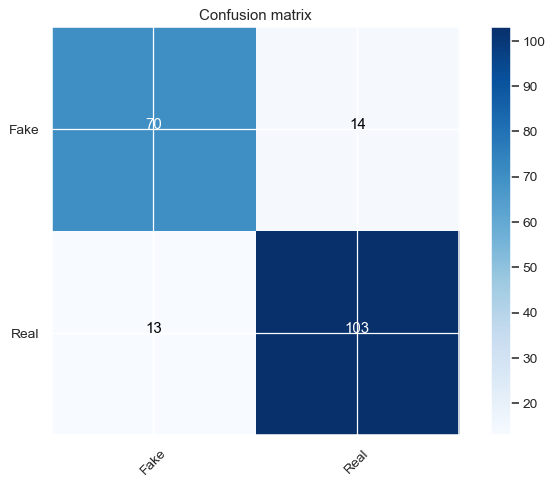

In [94]:
# check confusion matrix 
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Decision Tree

In [96]:
from sklearn.tree import DecisionTreeClassifier
# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)
# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 80.5%


Confusion matrix, without normalization


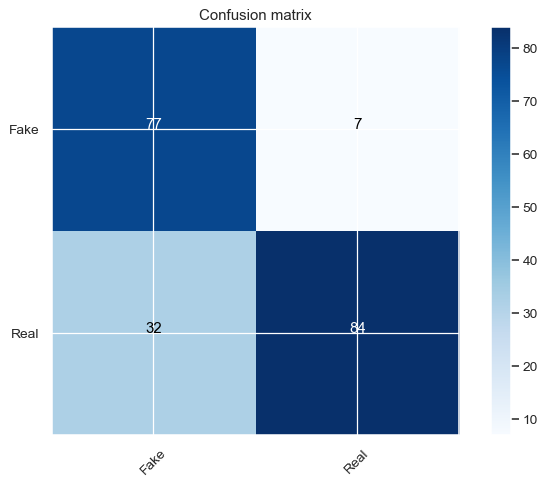

In [98]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Random Forest Classifier

In [99]:
from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 86.0%


Confusion matrix, without normalization


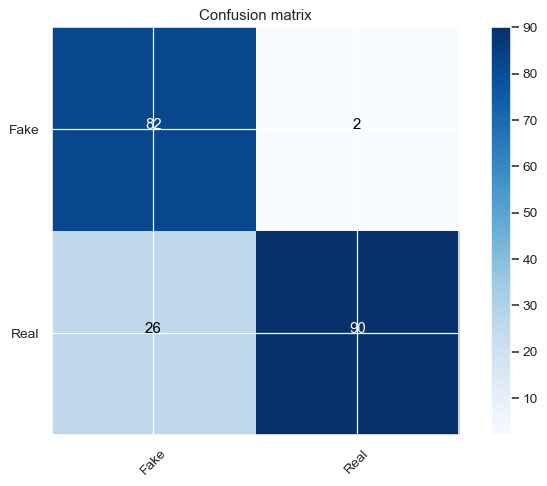

In [100]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### SVM

In [104]:
from sklearn import naive_bayes, svm

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'))])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 88.0%


Confusion matrix, without normalization


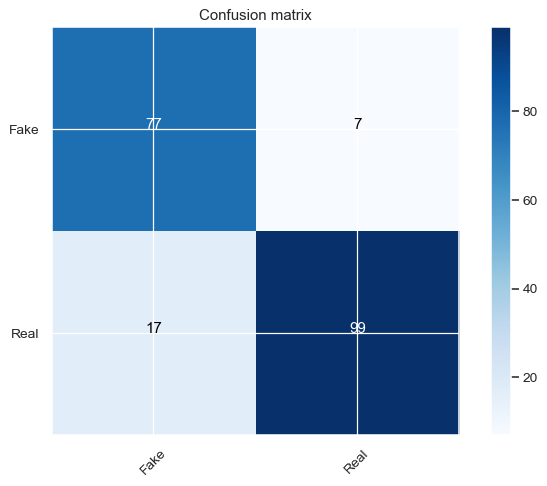

In [105]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Naive Bayes

In [107]:
from sklearn import naive_bayes, svm

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', naive_bayes.MultinomialNB())])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 82.5%


Confusion matrix, without normalization


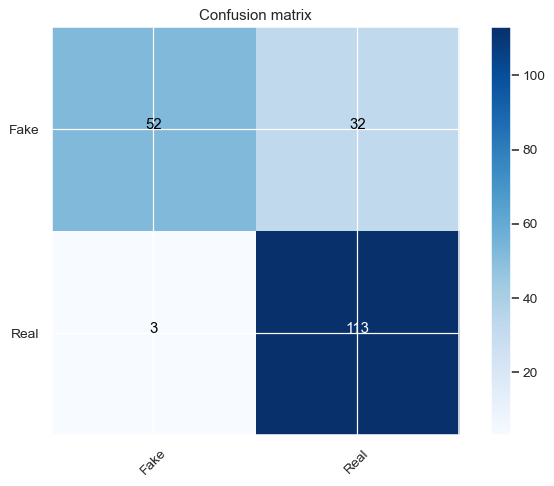

In [108]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])